In [1]:
import mamba_ssm
import torch
import matplotlib.pyplot as plt
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    return total_params

/home/ubuntu/Test/mamba/mamba_ssm/ops/selective_scan_interface.py:163: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @custom_fwd
/home/ubuntu/Test/mamba/mamba_ssm/ops/selective_scan_interface.py:239: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  @custom_bwd
/home/ubuntu/Test/mamba/mamba_ssm/ops/triton/layer_norm.py:985: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @custom_fwd
/home/ubuntu/Test/mamba/mamba_ssm/ops/triton/layer_norm.py:1044: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  @custom_bwd
/home/ubuntu/Test/mamba/mamba_ssm/distributed/tensor_parallel.py:25: FutureWarning: `torch.cuda.amp.custom_fwd(args..

In [2]:
#from mamba import Mamba2
from mamba_ssm.modules.mamba2 import Mamba2

In [3]:
layer = Mamba2(256)

In [4]:
layer.to('cuda')
out = layer(torch.randn(2,128,256).cuda())

ValueError: Default process group has not been initialized, please make sure to call init_process_group.

In [ ]:
out[-1,-1,-1].backward()

In [ ]:
for n,p in layer.named_parameters():
    print(n, 'param', p)
    print(n, ' grad', p.grad)

In [ ]:
import math
from collections import defaultdict
pow = range(6,12)
print([2**p for p in pow])
pdict = defaultdict(list)
for apow in pow:
    for n, p in Mamba2(2**apow).named_parameters():
        pdict[n].append(math.log(p.numel()))
for k,v in pdict.items():
    plt.figure()
    plt.plot(pow,v)
    plt.title(k)

In [ ]:
import os
import torch
dist_dir = 'par_save'
ser_dir = 'ser_save'
files = ['input','dt','dA_cumsum','passed_states', 'states','dA_cumsum_prev']
dist_dict = {}
num_gpus=8
dir = dist_dir
for file in files:
    dist_dict[file] = torch.cat([torch.load(os.path.join(dir, f"{file}_{gpu}.pt")).detach().cpu() for gpu in range(num_gpus)], dim=1)
num_gpus=1
dir = ser_dir
ser_dict = {}
for file in files:
    ser_dict[file] = torch.cat([torch.load(os.path.join(dir, f"{file}_{gpu}.pt")).detach().cpu() for gpu in range(num_gpus)], dim=1)

In [ ]:
for k,v in ser_dict.items():
    print(k,v.shape)
for k,v in dist_dict.items():
    print(k,v.shape)

In [ ]:
print(8192/256, 'num chunks')
print(256*2/64, 'num_heads')

In [ ]:
for i in range(8):
    #plt.figure()
    plt.plot(ser_dict['input'][i,:,0]-dist_dict['input'][i,:,0])

In [ ]:
sequence = torch.cat(torch.load('par_save/sequence_0.pt'), dim=1).cpu()
seq_gpu = torch.cat([torch.load(os.path.join('par_save', f"input_{gpu}.pt")).detach().cpu() for gpu in range(8)], dim=1)
print(sequence.shape, seq_gpu.shape)
plt.plot(seq_gpu[:,24,0])
plt.plot(sequence[:,24,0])
plt.figure()
plt.plot(seq_gpu[1,:,0])
plt.plot(sequence[1,:,0])
plt.figure()
plt.plot(seq_gpu[0,:,0])
plt.plot(sequence[0,:,0])
#plt.plot(seq_gpu[4,:,:].flatten()-sequence[4,:,:].flatten())
#plt.plot(dist_dict['input'][0,:,0].flatten()-sequence[2,:,:].flatten())
#plt.figure()
#plt.plot(ser_dict['input'][2,:,:].flatten()-sequence[2,:,:].flatten())


In [ ]:
for i in range(2):
    plt.figure()
    #plt.plot(ser_dict['dA_cumsum'].sum(dim=(2,3))[i,:], 'o')
    #plt.plot(dist_dict['dA_cumsum'].sum(dim=(2,3))[i,:],'x')
    plt.plot(ser_dict['dt'][i,:,0]-dist_dict['dt'][i,:,0])

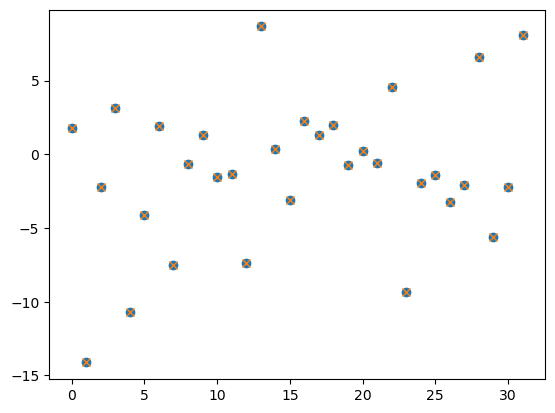

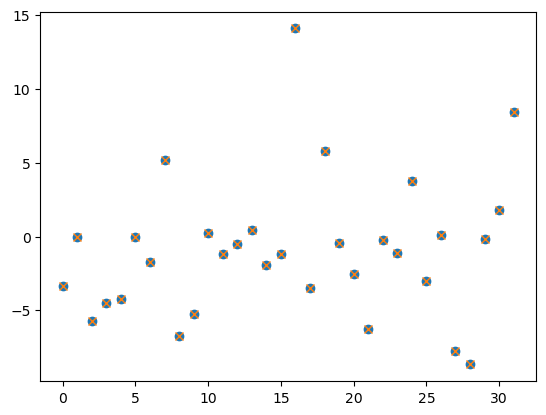

In [163]:
for i in range(2):
    plt.figure()
    plt.plot(ser_dict['states'].sum(dim=(2,3,4))[i,:], 'o')
    plt.plot(dist_dict['states'].sum(dim=(2,3,4))[i,:],'x')

In [ ]:
for i in range(8):
    plt.figure()
    plt.plot(ser_dict['passed_states'].sum(dim=(2,3,4))[i,:],'o')
    plt.plot(dist_dict['passed_states'].sum(dim=(2,3,4))[i,:],'x')

In [5]:
plt.plot([x.mean() for x in dist_dict['states']])

NameError: name 'dist_dict' is not defined

In [6]:
plt.plot([x.mean() for x in dist_dict['states']])

NameError: name 'dist_dict' is not defined

In [7]:
import torch.nn.functional as F
def state_passing_ref(states, dA_chunk_cumsum, initial_states=None):
    """
    Argument:
        states: (batch, nchunks, nheads, dim)
        dA_chunk_cumsum: (batch, nheads, nchunks)
        initial_states: (batch, nheads, dim)
    Return:
        out: (batch, nchunks, nheads, dim)
        final_states: (batch, nheads, dim)
    """
    if initial_states is None:
        initial_states = torch.zeros_like(states[:, 0])
    states = torch.cat([rearrange(initial_states, "b h d -> b 1 h d"), states], dim=1)
    dA_chunk_cumsum = F.pad(dA_chunk_cumsum, (1, 0))
    dA_chunk_cumsum = torch.cumsum(dA_chunk_cumsum, dim=-1)
    nchunks = dA_chunk_cumsum.shape[-1]
    # (batch, nheads, nchunks, nchunks)
    dt_chunk_segment_sum = dA_chunk_cumsum[:, :, :, None] - dA_chunk_cumsum[:, :, None, :]
    # (batch, nheads, nchunks, nchunks)
    decay_chunk = torch.exp(dt_chunk_segment_sum)
    causal_mask = torch.tril(torch.ones(nchunks, nchunks, device=states.device, dtype=bool), diagonal=0)
    decay_chunk = decay_chunk.masked_fill(~causal_mask, 0)
    out = torch.einsum("bhzc,bchd->bzhd", decay_chunk.to(dtype=states.dtype), states)
    return out[:, :-1], out[:, -1]

In [8]:
from einops import rearrange
from mamba_ssm.ops.triton.ssd_state_passing import _state_passing_fwd
def pass_states(dA_cumsum, states, initial_states=None, seq_idx=None, chunk_size=128):
    print(states.shape)
    #print(dA_cumsum.shape)
    initial_states = initial_states.to('cuda') if initial_states is not None else initial_states
    dstate = states.shape[-1]
    states = states.to('cuda')
    dA_cumsum = rearrange(dA_cumsum,'i j k l -> i k j l').to('cuda')
    #states, final_states = _state_passing_fwd(rearrange(states, "... p n -> ... (p n)"), dA_cumsum[:, :, :, -1],
    #                                              initial_states=rearrange(initial_states, "... p n -> ... (p n)") if initial_states is not None else None,
    #                                              seq_idx=seq_idx, chunk_size=chunk_size, out_dtype=torch.float32)
    states, final_states = state_passing_ref(rearrange(states, "... p n -> ... (p n)"), dA_cumsum[:, :, :, -1],
                                             initial_states=rearrange(initial_states, "... p n -> ... (p n)") if initial_states is not None else None)
    states, final_states = [rearrange(t, "... (p n) -> ... p n", n=dstate) for t in [states, final_states]]
    return states, final_states
        

In [4]:
import os
import torch
dist_dir = 'par_save'
ser_dir = 'ser_save'
files = ['input','dt','dA_cumsum','passed_states', 'states','final_states']
dist_dict = {}
num_gpus=8
dir = dist_dir
for file in files:
    dist_dict[file] = [torch.load(os.path.join(dir, f"{file}_{gpu}.pt"), map_location='cpu').detach() for gpu in range(num_gpus)]
num_gpus=1
dir = ser_dir
ser_dict = {}
for file in files:
    ser_dict[file] = [torch.load(os.path.join(dir, f"{file}_{gpu}.pt"), map_location='cpu').detach() for gpu in range(num_gpus)]

FileNotFoundError: [Errno 2] No such file or directory: 'par_save/dt_0.pt'

IndexError: Dimension out of range (expected to be in range of [-3, 2], but got 3)

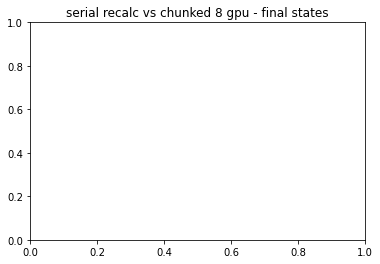

In [50]:
plt.figure()
plt.title('serial recalc vs chunked 8 gpu - final states')
plt.plot((ser_dict['input'][0].sum(dim=(2,3,4))[1,:]-torch.concat(dist_dict['input'], dim=1).sum(dim=(2,3,4))[1,:]),'^')
#vlines = range(0,32,4)
#plt.vlines(vlines,-0.1,0.1,'r',alpha=0.2)

In [141]:
ser_dict['repassed_states'] = [pass_states(ser_dict['dA_cumsum'][0],ser_dict['states'][0])[0].cpu()]
dist_dict['repassed_states0'] = [pass_states(torch.cat(dist_dict['dA_cumsum'], dim=1),
                                             torch.cat(dist_dict['states'], dim=1))[0].cpu()]

dist_dict['repassed_states'] = [pass_states(dist_dict['dA_cumsum'][0],dist_dict['states'][0])[0].cpu()]
for dA_cumsum, state, final_state in zip(dist_dict['dA_cumsum'][1:],dist_dict['states'][1:],dist_dict['final_states']):
    dist_dict['repassed_states'].append(pass_states(dA_cumsum, state, final_state)[0].cpu())
state, final_state = pass_states(dist_dict['dA_cumsum'][0],dist_dict['states'][0])
dist_dict['repassed_states2'] = [state.cpu()]
for dA_cumsum, state in zip(dist_dict['dA_cumsum'][1:],dist_dict['states'][1:]):
    state, final_state = pass_states(dA_cumsum, state)#, final_state)
    dist_dict['repassed_states2'].append(state.cpu())

state, final_state = pass_states(dist_dict['dA_cumsum'][0],dist_dict['states'][0])
dist_dict['repassed_states3'] = [state.cpu()]
dist_dict['correct_final_states'] = [final_state]
for dA_cumsum, state in zip(dist_dict['dA_cumsum'][1:],dist_dict['states'][1:]):
    state, final_state = pass_states(dA_cumsum, state, final_state.clone())
    dist_dict['correct_final_states'].append(final_state)
    dist_dict['repassed_states3'].append(state.cpu())

torch.Size([8, 32, 8, 64, 128])
torch.Size([8, 32, 8, 64, 128])
torch.Size([8, 4, 8, 64, 128])
torch.Size([8, 4, 8, 64, 128])
torch.Size([8, 4, 8, 64, 128])
torch.Size([8, 4, 8, 64, 128])
torch.Size([8, 4, 8, 64, 128])
torch.Size([8, 4, 8, 64, 128])
torch.Size([8, 4, 8, 64, 128])
torch.Size([8, 4, 8, 64, 128])
torch.Size([8, 4, 8, 64, 128])
torch.Size([8, 4, 8, 64, 128])
torch.Size([8, 4, 8, 64, 128])
torch.Size([8, 4, 8, 64, 128])
torch.Size([8, 4, 8, 64, 128])
torch.Size([8, 4, 8, 64, 128])
torch.Size([8, 4, 8, 64, 128])
torch.Size([8, 4, 8, 64, 128])
torch.Size([8, 4, 8, 64, 128])
torch.Size([8, 4, 8, 64, 128])
torch.Size([8, 4, 8, 64, 128])
torch.Size([8, 4, 8, 64, 128])
torch.Size([8, 4, 8, 64, 128])
torch.Size([8, 4, 8, 64, 128])
torch.Size([8, 4, 8, 64, 128])
torch.Size([8, 4, 8, 64, 128])


Text(0, 0.5, '$h$')

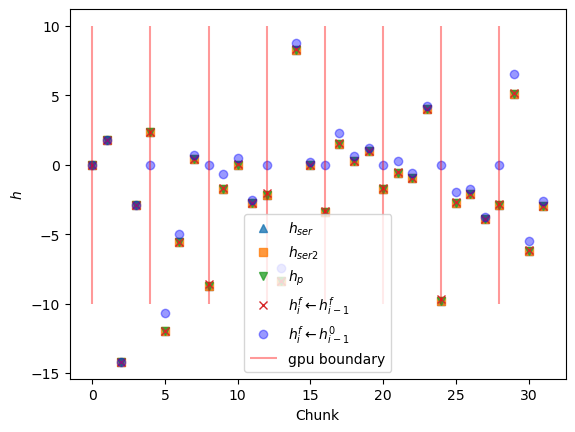

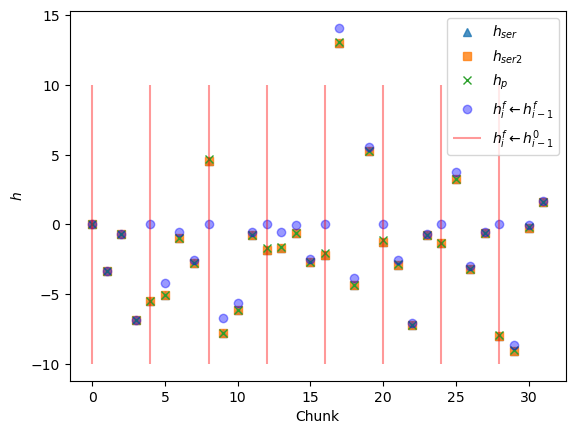

In [142]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(ser_dict['passed_states'][0].sum(dim=(2,3,4))[0,:],'^',alpha=0.8)
plt.plot(ser_dict['repassed_states'][0].sum(dim=(2,3,4))[0,:],'s',alpha=0.8)
plt.plot(dist_dict['repassed_states0'][0].sum(dim=(2,3,4))[0,:],'v',alpha=0.8)

plt.plot(torch.concat(dist_dict['repassed_states'], dim=1).sum(dim=(2,3,4))[0,:],'x')
plt.plot(torch.concat(dist_dict['repassed_states2'], dim=1).sum(dim=(2,3,4))[0,:],'bo', alpha=0.4)
vlines = range(0,32,4)
plt.vlines(vlines,-10,10,'r',alpha=0.4)
plt.legend(['$h_{ser}$','$h_{ser2}$','$h_p$','$h^f_{i}\leftarrow h^f_{i-1}$','$h^f_{i}\leftarrow h^0_{i-1}$','gpu boundary'])
plt.xlabel('Chunk')
plt.ylabel('$h$')
plt.figure()
plt.plot(ser_dict['passed_states'][0].sum(dim=(2,3,4))[1,:],'^',alpha=0.8)
plt.plot(ser_dict['repassed_states'][0].sum(dim=(2,3,4))[1,:],'s',alpha=0.8)
plt.plot(torch.concat(dist_dict['repassed_states'], dim=1).sum(dim=(2,3,4))[1,:],'x')
plt.plot(torch.concat(dist_dict['repassed_states2'], dim=1).sum(dim=(2,3,4))[1,:],'bo',alpha=0.4)
vlines = range(0,32,4)
plt.vlines(vlines,-10,10,'r',alpha=0.4)
plt.legend(['$h_{ser}$','$h_{ser2}$','$h_p$','$h^f_{i}\leftarrow h^f_{i-1}$','$h^f_{i}\leftarrow h^0_{i-1}$','gpu boundary'])
plt.xlabel('Chunk')
plt.ylabel('$h$')

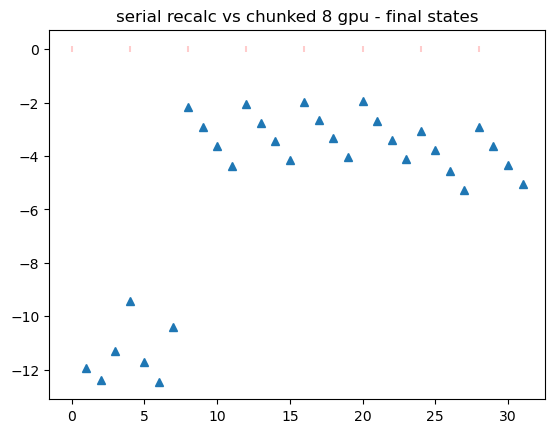

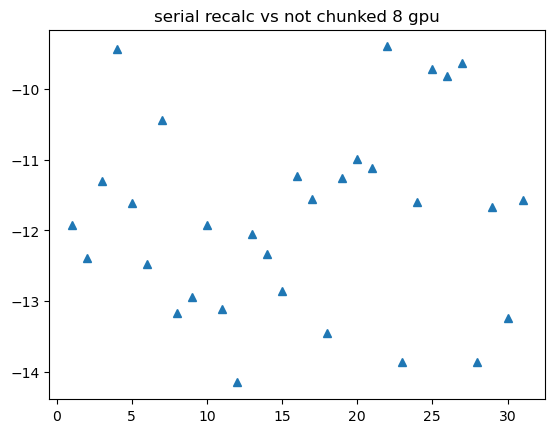

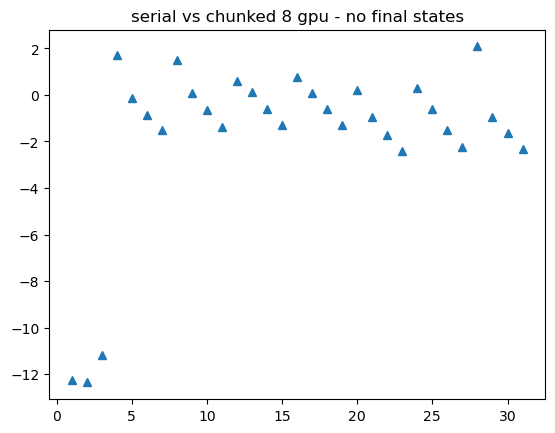

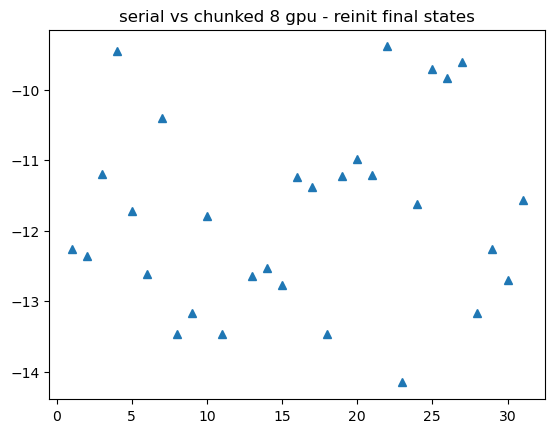

In [144]:
plt.figure()
plt.title('serial recalc vs chunked 8 gpu - final states')
plt.plot((ser_dict['repassed_states'][0].sum(dim=(2,3,4))[1,:]-torch.concat(dist_dict['repassed_states'], dim=1).sum(dim=(2,3,4))[1,:]).abs().log(),'^')
vlines = range(0,32,4)
plt.vlines(vlines,-0.1,0.1,'r',alpha=0.2)

plt.figure()
plt.title('serial recalc vs not chunked 8 gpu')
plt.plot((ser_dict['repassed_states'][0].sum(dim=(2,3,4))[1,:]-torch.concat(dist_dict['repassed_states0'], dim=1).sum(dim=(2,3,4))[1,:]).abs().log(),'^')
#vlines = range(0,32,4)
#plt.vlines(vlines,-0.1,0.1,'r',alpha=0.2)

plt.figure()
plt.title('serial vs chunked 8 gpu - no final states')
plt.plot((ser_dict['passed_states'][0].sum(dim=(2,3,4))[1,:]-torch.concat(dist_dict['repassed_states2'], dim=1).sum(dim=(2,3,4))[1,:]).abs().log(),'^')
#vlines = range(0,32,4)
#plt.vlines(vlines,-0.00001,0.00001,'r',alpha=0.2)

plt.figure()
plt.title('serial vs chunked 8 gpu - reinit final states')
plt.plot((ser_dict['passed_states'][0].sum(dim=(2,3,4))[1,:]-torch.concat(dist_dict['repassed_states3'], dim=1).sum(dim=(2,3,4))[1,:]).abs().log(),'^')
#vlines = range(0,32,4)
#plt.vlines(vlines,-0.00001,0.00001,'r',alpha=0.2)

dA_cumsum[0].shape = torch.Size([8, 4, 8, 256])
final_states[0].shape = torch.Size([8, 8, 64, 128])
expdA_f[0].shape = torch.Size([8, 8, 1, 1])
expdA[0].shape = torch.Size([8, 8, 1, 1])


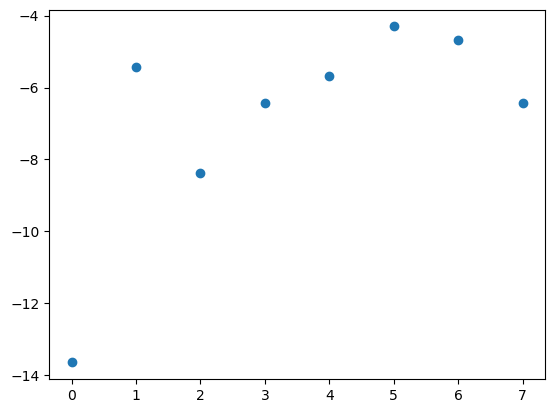

In [155]:
from einops import reduce
def update_final_states(final_states,dA_cumsum, chunks_per_gpu):
    """
    updates final states
    h^f_k = sum_i=0..k-1 h^f_i prod_j=i..k-1 A_j
    """
    final_states_updated = [final_states[0]]
    print(f"{dA_cumsum[0].shape = }")
    print(f"{final_states[0].shape = }")

    expdA = [torch.prod(torch.exp(x[:, :-1, :, -1]), dim=1)[:,:,None,None] for x in dA_cumsum]
    expdA_f = [torch.exp(x[:,-1,:,-1])[:,:,None, None] for x in dA_cumsum]
    print(f"{expdA_f[0].shape = }")
    print(f"{expdA[0].shape = }")
    #expdA = reduce(expdA, 'b (g c) d -> b g d', 'prod', c = chunks_per_gpu)
    #print(f"{expdA.shape = }")
    for k,hfk in enumerate(final_states[1:],start=1):
        res = hfk.clone() #TODO tensor
        for i in range(k):
            scale = 1.0 #expdA[i]
            for j in range(i,k):
                scale *= expdA_f[j]
                #print('state',k,'substate',i,'fscale',j)
            for j in range(i,k):
                #print('state',k,'substate',i,'scale',j)
                scale *= expdA[j]
            #print('states',k,'substate',i)
            res += final_states[i] * scale
            #res += final_states[i] * scale 
        final_states_updated.append(res)
    return final_states_updated
dist_dict['updated_final_states'] = update_final_states(dist_dict['final_states'],dist_dict['dA_cumsum'], 4)
#for x in dist_dict['updated_final_states']:
#    print(x.shape)
plt.plot((torch.cat([x.sum(dim=(1,2,3)).unsqueeze(1) for x in dist_dict['updated_final_states']], 
                    dim=1)[0]-torch.cat([x.sum(dim=(1,2,3)).unsqueeze(1).cpu() for x in dist_dict['correct_final_states']], 
                                        dim=1)[0]).abs().log(),'o')

torch.Size([8, 4, 8, 64, 128])
torch.Size([8, 4, 8, 64, 128])
torch.Size([8, 4, 8, 64, 128])
torch.Size([8, 4, 8, 64, 128])
torch.Size([8, 4, 8, 64, 128])
torch.Size([8, 4, 8, 64, 128])
torch.Size([8, 4, 8, 64, 128])
torch.Size([8, 4, 8, 64, 128])
torch.Size([32])
tensor([0.0000e+00, 4.7684e-06, 4.1127e-06, 1.3828e-05, 8.0109e-05, 8.5831e-06,
        3.3379e-06, 2.9802e-05, 9.8325e-02, 4.7439e-02, 2.3624e-02, 1.1120e-02,
        1.1276e-01, 5.5252e-02, 2.7994e-02, 1.3776e-02, 1.2183e-01, 6.2683e-02,
        3.1254e-02, 1.5830e-02, 1.2373e-01, 6.0591e-02, 2.9038e-02, 1.4254e-02,
        4.0100e-02, 1.9827e-02, 9.1693e-03, 4.4689e-03, 4.7822e-02, 2.3101e-02,
        1.1555e-02, 5.6258e-03])


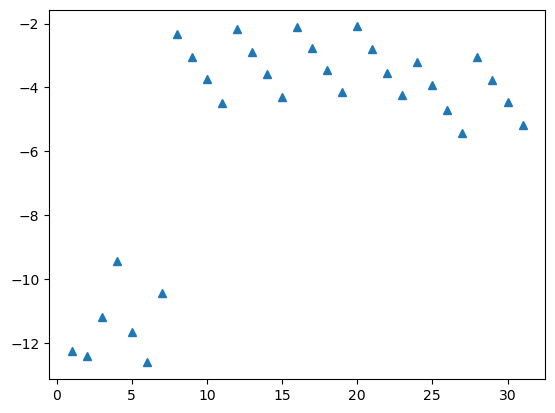

In [123]:
import matplotlib.pyplot as plt
dist_dict['repassed_states4'] = [pass_states(dist_dict['dA_cumsum'][0],dist_dict['states'][0])[0].cpu()]
for dA_cumsum, state, final_state in zip(dist_dict['dA_cumsum'][1:],dist_dict['states'][1:],dist_dict['updated_final_states']):
    dist_dict['repassed_states4'].append(pass_states(dA_cumsum, state, final_state)[0].cpu())
print(torch.concat(dist_dict['repassed_states4'], dim=1).sum(dim=(2,3,4))[1,:].shape)
print((ser_dict['passed_states'][0].sum(dim=(2,3,4))[1,:]-torch.concat(dist_dict['repassed_states4'], dim=1).sum(dim=(2,3,4))[1,:]).abs())
#plt.figure()
#plt.title('serial vs chunked 8 gpu - reinit final states')
plt.plot((ser_dict['passed_states'][0].sum(dim=(2,3,4))[1,:]-torch.concat(dist_dict['repassed_states4'], dim=1).sum(dim=(2,3,4))[1,:]).abs(),'^')
#vlines = range(0,32,4)
#plt.vlines(vlines,-0.00001,0.00001,'r',alpha=0.2)

In [57]:
def reduce(tensor_list, states, dA_cumsum, chunks_per_gpu):
    """
    states are the passed states for a gpu
    tesnor list is the list of final states per gpu (passed but not with states form other gpus)
    
    """
    rank = len(tensor_list)
    states_per_gpu = states.shape[1]
    print('rank',rank)
    #if rank == 1:
    #    return states
    expdA = torch.exp(dA_cumsum[:, :, :, -1]) #dA_cumsum (b,h,c,dim_c) #State passing get's last element for some reason
    print(f"{expdA.shape = }")
    print('x,r,g,start,end')
    for x in range(states_per_gpu): #Intra GPU Chunk #
        for gpu,final_state in enumerate(tensor_list,start=1):
            #if gpu == rank:
            #    break
            start, end = gpu*chunks_per_gpu-1, rank*chunks_per_gpu+x
            #print(x, rank, gpu, start,end)
            scale = torch.prod(expdA[:,:,start:end], dim = 2)
            #print(scale.shape, states[:,i,:,:].shape)
            scale = scale[:,:,None,None]
            #print(scale)
            states[:,x,:,:] += final_state*scale
    return states

def reduce_ref(states, dA_cumsum):
    nstates = states.shape[1]
    states_out = []
    #print(states.shape)
    state = torch.zeros_like(states[:,0,:,:])
    expdA = torch.exp(dA_cumsum[:, :, :, -1])
    for i in range(nstates):
        scale = torch.exp(expdA[:,i,:])
        state = state + scale[:,:,None,None]*states[:,i,:,:]
        #print(state.shape)
        states_out.append(state.unsqueeze(1))
    return torch.concat(states_out, dim = 1)

In [ ]:
res1 = reduce_ref(torch.concat(dist_dict['states'], dim = 1).clone(),
                 torch.concat(dist_dict['dA_cumsum'], dim=1))
res2 = reduce_ref(ser_dict['states'].clone(),
                 ser_dict['dA_cumsum'])
#print(res.shape)

In [ ]:
from einops import rearrange
res = []
n_chunks_per_gpu = 32//8
res = torch.concat([reduce(dist_dict['final_states'][:rank],
              dist_dict['states'][rank].clone(),
              rearrange(torch.concat(dist_dict['dA_cumsum'],dim=1), 'i j k l -> i k j l'),
              n_chunks_per_gpu,) if rank else dist_dict['states'][rank].clone() for rank in range(0,8)], dim=1)

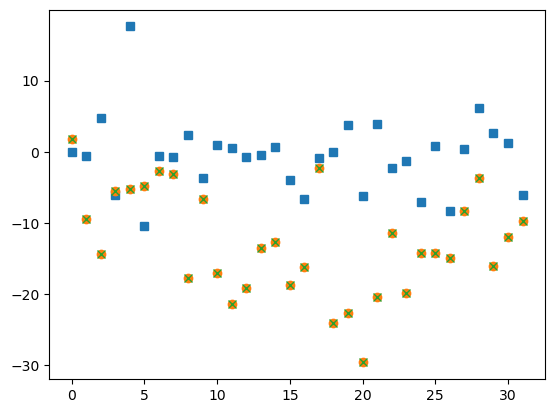

In [59]:
import matplotlib.pyplot as plt
plt.plot(ser_dict['passed_states'].sum(dim=(2,3,4))[0,:],'s')
plt.plot(res1.sum(dim=(2,3,4))[0,:],'o')
plt.plot(res2.sum(dim=(2,3,4))[0,:],'x')
#plt.plot(torch.concat(dist_dict['states'], dim=1).sum(dim=(2,3,4))[0,:],'x')

In [2]:
import torch.distributed as dist
mesh_1d = dist.device_mesh.init_device_mesh("cuda", mesh_shape=(8,))

ValueError: Error initializing torch.distributed using env:// rendezvous: environment variable RANK expected, but not set

In [98]:
torch.tensor([0,1,2,3,4])[:-1]

tensor([0, 1, 2, 3])

In [235]:
def state_passing_test(states, dA_chunk_cumsum, initial_states=None):
    """
    Argument:
        states: (nchunks, dim)
        dA_chunk_cumsum: (batch, nheads, nchunks)
        initial_states: (batch, nheads, dim)
    Return:
        out: (batch, nchunks, nheads, dim)
        final_states: (batch, nheads, dim)
    """
    if initial_states is None:
        initial_states = torch.zeros_like(states[0])
        print(rearrange(initial_states, "d -> 1 d").shape)
    print(f"{states.shape = }")
    states = torch.cat([rearrange(initial_states, "d -> 1 d"), states], dim=0)
    dA_chunk_cumsum = F.pad(dA_chunk_cumsum, (1, 0))
    dA_chunk_cumsum = torch.cumsum(dA_chunk_cumsum, dim=-1)
    nchunks = dA_chunk_cumsum.shape[-1]
    # (batch, nheads, nchunks, nchunks)
    dt_chunk_segment_sum = dA_chunk_cumsum[:, None] - dA_chunk_cumsum[None, :]
    print(f"{dt_chunk_segment_sum = }")
    # (batch, nheads, nchunks, nchunks)
    #decay_chunk = torch.exp(dt_chunk_segment_sum)
    decay_chunk=dt_chunk_segment_sum
    print(f"{decay_chunk.shape = }")
    causal_mask = torch.tril(torch.ones(nchunks, nchunks, device=states.device, dtype=bool), diagonal=0)
    print(f"{causal_mask.shape = }")
    decay_chunk = decay_chunk.masked_fill(~causal_mask, 0)
    print(f"{decay_chunk = }")
    out = torch.einsum("zc,cd->zd", decay_chunk.to(dtype=states.dtype), states)
    return out[:-1], out[-1]

In [317]:
chunks=6
gchunk=2
states = torch.ones([chunks,3]).cumsum(1)
#states[-1] = 0
print(states)
dA_chunk_cumsum = torch.ones([chunks])#.cumsum(0)
#dA_chunk_cumsum[3] += 2
print(f"{dA_chunk_cumsum = }")
fout = torch.zeros(3)
sout_0, fout_0 = state_passing_test(states,dA_chunk_cumsum)
all_sout=[]
all_fout=[]
for i in range(0,chunks//gchunk):
    j = i+1
    print(f"{i*gchunk}:{j*gchunk}")
    sout,fout = state_passing_test(states[i*gchunk:j*gchunk],
                                   dA_chunk_cumsum[i*gchunk:j*gchunk],
                                  initial_states=fout)
    all_sout.append(sout)
    all_fout.append(fout)
print(fout)
print(fout_0)
print(torch.cat(all_sout))
print(sout_0)

tensor([[1., 2., 3.],
        [1., 2., 3.],
        [1., 2., 3.],
        [1., 2., 3.],
        [1., 2., 3.],
        [1., 2., 3.]])
dA_chunk_cumsum = tensor([1., 1., 1., 1., 1., 1.])
torch.Size([1, 3])
states.shape = torch.Size([6, 3])
dt_chunk_segment_sum = tensor([[ 0., -1., -2., -3., -4., -5., -6.],
        [ 1.,  0., -1., -2., -3., -4., -5.],
        [ 2.,  1.,  0., -1., -2., -3., -4.],
        [ 3.,  2.,  1.,  0., -1., -2., -3.],
        [ 4.,  3.,  2.,  1.,  0., -1., -2.],
        [ 5.,  4.,  3.,  2.,  1.,  0., -1.],
        [ 6.,  5.,  4.,  3.,  2.,  1.,  0.]])
decay_chunk.shape = torch.Size([7, 7])
causal_mask.shape = torch.Size([7, 7])
decay_chunk = tensor([[0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [2., 1., 0., 0., 0., 0., 0.],
        [3., 2., 1., 0., 0., 0., 0.],
        [4., 3., 2., 1., 0., 0., 0.],
        [5., 4., 3., 2., 1., 0., 0.],
        [6., 5., 4., 3., 2., 1., 0.]])
0:2
states.shape = torch.Size([2, 3])
dt_chunk_segment_sum = tens

In [260]:
all_fout

[tensor([1., 2., 3.]), tensor([1., 2., 3.])]

In [226]:
all_sout

[tensor([[0., 0.],
         [0., 0.],
         [2., 2.]]),
 tensor([[0., 0.],
         [0., 0.],
         [5., 5.]]),
 tensor([[0., 0.],
         [0., 0.],
         [8., 8.]])]

In [227]:
dA_chunk_cumsum

tensor([1., 2., 3., 4., 5., 6., 7., 8., 9.])

Given all_fout, all_sout, and dA_chunk_cumsum, update all_sout to be sout_0 without using any sharing of information between all_sout elements

In [241]:
for x in range(3):
    sout,fout = state_passing_test(states,
                                       dA_chunk_cumsum,
                                      initial_states=torch.ones(2)*x)
    print(sout)
    print(fout)

states.shape = torch.Size([4, 2])
dt_chunk_segment_sum = tensor([[  0.,  -1.,  -3.,  -6., -11.],
        [  1.,   0.,  -2.,  -5., -10.],
        [  3.,   2.,   0.,  -3.,  -8.],
        [  6.,   5.,   3.,   0.,  -5.],
        [ 11.,  10.,   8.,   5.,   0.]])
decay_chunk.shape = torch.Size([5, 5])
causal_mask.shape = torch.Size([5, 5])
decay_chunk = tensor([[ 0.,  0.,  0.,  0.,  0.],
        [ 1.,  0.,  0.,  0.,  0.],
        [ 3.,  2.,  0.,  0.,  0.],
        [ 6.,  5.,  3.,  0.,  0.],
        [11., 10.,  8.,  5.,  0.]])
tensor([[0., 0.],
        [0., 0.],
        [2., 2.],
        [8., 8.]])
tensor([23., 23.])
states.shape = torch.Size([4, 2])
dt_chunk_segment_sum = tensor([[  0.,  -1.,  -3.,  -6., -11.],
        [  1.,   0.,  -2.,  -5., -10.],
        [  3.,   2.,   0.,  -3.,  -8.],
        [  6.,   5.,   3.,   0.,  -5.],
        [ 11.,  10.,   8.,   5.,   0.]])
decay_chunk.shape = torch.Size([5, 5])
causal_mask.shape = torch.Size([5, 5])
decay_chunk = tensor([[ 0.,  0.,  0.,  0.,  0.

In [246]:
q=torch.Tensor([0,1,5])
q[:,None]-q[None,:]

tensor([[ 0., -1., -5.],
        [ 1.,  0., -4.],
        [ 5.,  4.,  0.]])

In [261]:
from sympy import *

In [311]:
var('A1 A2 A3 A4')
A_cumsum = Matrix([[0, 0, 0, 0,0], 
                   [A1, 0, 0,0,0],
                   [A2, A2-A1,0,0,0],
                   [A3,A3-A1,A3-A2,0,0],
                   [A4, A4-A1, A4-A2, A4-A3,0],
                  ]).applyfunc(lambda x: exp(x) if x else 0)
A_cumsum1 = Matrix([[0,0,0],
                   [A1,0,0],
                   [A2, A2-A1, 0]]).applyfunc(lambda x: exp(x) if x else 0)
A_cumsum2 = Matrix([[0,0,0],
                   [A3,0,0],
                   [A4,A4-A3,0]]).applyfunc(lambda x: exp(x) if x else 0)

In [312]:
pprint(A_cumsum)
pprint(A_cumsum1)
pprint(A_cumsum2)

⎡ 0       0          0          0      0⎤
⎢                                       ⎥
⎢ A₁                                    ⎥
⎢ℯ        0          0          0      0⎥
⎢                                       ⎥
⎢ A₂   -A₁ + A₂                         ⎥
⎢ℯ    ℯ              0          0      0⎥
⎢                                       ⎥
⎢ A₃   -A₁ + A₃   -A₂ + A₃              ⎥
⎢ℯ    ℯ          ℯ              0      0⎥
⎢                                       ⎥
⎢ A₄   -A₁ + A₄   -A₂ + A₄   -A₃ + A₄   ⎥
⎣ℯ    ℯ          ℯ          ℯ          0⎦
⎡ 0       0      0⎤
⎢                 ⎥
⎢ A₁              ⎥
⎢ℯ        0      0⎥
⎢                 ⎥
⎢ A₂   -A₁ + A₂   ⎥
⎣ℯ    ℯ          0⎦
⎡ 0       0      0⎤
⎢                 ⎥
⎢ A₃              ⎥
⎢ℯ        0      0⎥
⎢                 ⎥
⎢ A₄   -A₃ + A₄   ⎥
⎣ℯ    ℯ          0⎦


In [305]:
var('hi, hw, hx, hy, hz')
states = Matrix([0, hw, hx, hy, hz])
states1 = Matrix([0,hw,hx])
states2 = Matrix([0,hy,hz])
hi = 0

In [313]:
pprint(A_cumsum.multiply(states))
pprint(A_cumsum1.multiply(states1))
pprint(A_cumsum2.multiply(states2))

⎡                    0                     ⎤
⎢                                          ⎥
⎢                    0                     ⎥
⎢                                          ⎥
⎢                   -A₁ + A₂               ⎥
⎢               hw⋅ℯ                       ⎥
⎢                                          ⎥
⎢           -A₁ + A₃       -A₂ + A₃        ⎥
⎢       hw⋅ℯ         + hx⋅ℯ                ⎥
⎢                                          ⎥
⎢    -A₁ + A₄       -A₂ + A₄       -A₃ + A₄⎥
⎣hw⋅ℯ         + hx⋅ℯ         + hy⋅ℯ        ⎦
⎡     0      ⎤
⎢            ⎥
⎢     0      ⎥
⎢            ⎥
⎢    -A₁ + A₂⎥
⎣hw⋅ℯ        ⎦
⎡     0      ⎤
⎢            ⎥
⎢     0      ⎥
⎢            ⎥
⎢    -A₃ + A₄⎥
⎣hy⋅ℯ        ⎦


Matrix([
[ 0],
[hw],
[hx]])

In [91]:
import pandas as pd
df_s = pd.read_csv('ser_save/res_0.csv', index_col=0)
df_s = df_s[df_s['it']>1].groupby(['exp']).mean()
df_s

,it,res,all,time
exp,,,,
8,2.5,6.962545e+08,1.619676e+08,3.135696
9,2.5,9.688842e+08,3.140767e+08,5.927200
10,2.5,2.046820e+09,6.167219e+08,11.516480
11,2.5,4.068475e+09,1.223061e+09,22.541921
12,2.5,8.648655e+09,2.435739e+09,44.726431
13,2.5,1.445147e+10,4.861485e+09,89.427425


In [96]:
df_p = pd.read_csv('par_save/res_1.csv', index_col=0)
df_p = df_p[df_p['it']>1].groupby(['exp']).mean()
#df_p['exp']=df_p['exp']/8

In [101]:
plt.figure()
plt.plot(df_s.time)

KeyError: '[5, 6, 7] not in index'

<Figure size 640x480 with 0 Axes>

In [6]:
import matplotlib.pyplot as plt
for x in ['all','res','time']:
    plt.figure()
    plt.plot(df_s.index+3,df_s[x])
    plt.plot(df_p.index+3,df_p[x])
    plt.yscale('log')
    plt.xlabel('$2^n$ sequence length')
    plt.ylabel(x)

NameError: name 'df_s' is not defined

<Figure size 640x480 with 0 Axes>

In [16]:
import os
import torch
dist_dir = 'par_save'
ser_dir = 'ser_save'
files = ['input','output', 'grad_dict']
#files = ['input','output', 'grad_dict','ddt','ddt_given','z','dz','dz_i','dout','dy_rms','rmsnorm_weight','rstd','x_rms','z_rms', 'out'] #,'states','passed_states','final_states','dstates','dpassed_states','bw_states','ddA_chunk_cumsum']
#files = ['input','output','grad_dict','dout','ddt','dz','dx','dC','dB','dxBC_p','zxbcdt','xBC_conv','dxBC','dxBC_given','dzxbcdt']
dist_dict = {}
num_gpus=8
dir = dist_dir
for file in files:
    dist_dict[file] = [torch.load(os.path.join(dir, f"{file}_{gpu}.pt"), map_location='cpu') for gpu in range(num_gpus)]
num_gpus=1
dir = ser_dir
ser_dict = {}
for file in files:
    ser_dict[file] = [torch.load(os.path.join(dir, f"{file}_{gpu}.pt"), map_location='cpu') for gpu in range(num_gpus)]

/tmp/ipykernel_18428/2726822527.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dist_dict[file] = [torch.load(os.path.join(dir, f"{file}_{gpu}.pt"), map_location='cpu')

In [17]:
print(dist_dict['input'][0].shape)
print(ser_dict['input'][0].shape)

torch.Size([8, 1024, 256])
torch.Size([8, 8192, 256])


Text(0.5, 1.0, 'fractional error of parallel ouptut to serial')

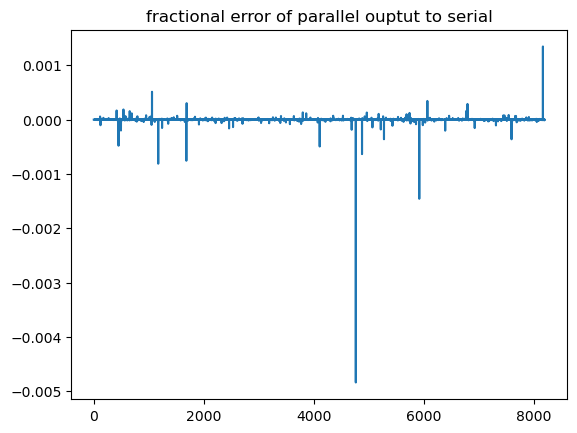

In [18]:
plt.plot((torch.cat(dist_dict['output'], dim=1).sum(dim=(0,2)).detach()-ser_dict['output'][0].sum(dim=(0,2)).detach()).div(ser_dict['output'][0].sum(dim=(0,2)).detach()))
#plt.yscale('log')
plt.title("fractional error of parallel ouptut to serial")

torch.Size([8]) torch.Size([8])
1.dt_bias torch.Size([8]) torch.Size([8]) tensor(4.8065e-06)
1.dt_bias plots
torch.Size([8]) torch.Size([8])
1.A_log torch.Size([8]) torch.Size([8]) tensor(5.0985e-07)
1.A_log plots
torch.Size([8]) torch.Size([8])
1.D torch.Size([8]) torch.Size([8]) tensor(1.2989e-07)
1.D plots
torch.Size([1288, 256]) torch.Size([1288, 256])
1.in_proj.weight torch.Size([1288, 256]) torch.Size([1288, 256]) tensor(5.0609e-06)
1.in_proj.weight plots
torch.Size([512]) torch.Size([512])
1.norm.weight torch.Size([512]) torch.Size([512]) tensor(1.6472e-05)
1.norm.weight plots
torch.Size([256, 512]) torch.Size([256, 512])
1.out_proj.weight torch.Size([256, 512]) torch.Size([256, 512]) tensor(1.0067e-06)
1.out_proj.weight plots
torch.Size([8]) torch.Size([8])
3.dt_bias torch.Size([8]) torch.Size([8]) tensor(2.2282e-06)
3.dt_bias plots
torch.Size([8]) torch.Size([8])
3.A_log torch.Size([8]) torch.Size([8]) tensor(4.5394e-07)
3.A_log plots
torch.Size([8]) torch.Size([8])
3.D torch.

/tmp/ipykernel_18428/2578791120.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


torch.Size([1288, 256]) torch.Size([1288, 256])
3.in_proj.weight torch.Size([1288, 256]) torch.Size([1288, 256]) tensor(3.4046e-06)
3.in_proj.weight plots
torch.Size([512]) torch.Size([512])
3.norm.weight torch.Size([512]) torch.Size([512]) tensor(2.8328e-07)
3.norm.weight plots
torch.Size([256, 512]) torch.Size([256, 512])
3.out_proj.weight torch.Size([256, 512]) torch.Size([256, 512]) tensor(6.7928e-07)
3.out_proj.weight plots
torch.Size([8]) torch.Size([8])
5.dt_bias torch.Size([8]) torch.Size([8]) tensor(7.4489e-07)
5.dt_bias plots
torch.Size([8]) torch.Size([8])
5.A_log torch.Size([8]) torch.Size([8]) tensor(1.7817e-07)
5.A_log plots
torch.Size([8]) torch.Size([8])
5.D torch.Size([8]) torch.Size([8]) tensor(1.8973e-07)
5.D plots
torch.Size([1288, 256]) torch.Size([1288, 256])
5.in_proj.weight torch.Size([1288, 256]) torch.Size([1288, 256]) tensor(1.1932e-06)
5.in_proj.weight plots
torch.Size([512]) torch.Size([512])
5.norm.weight torch.Size([512]) torch.Size([512]) tensor(6.5808e-

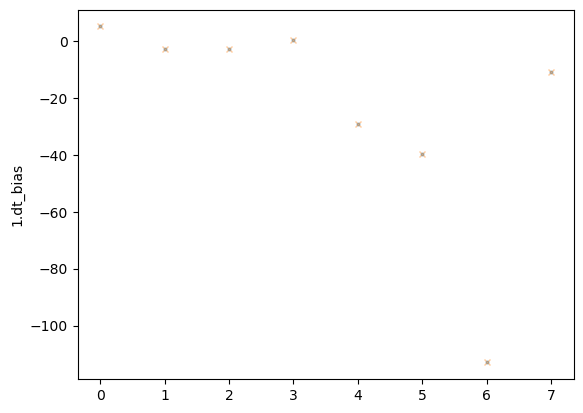

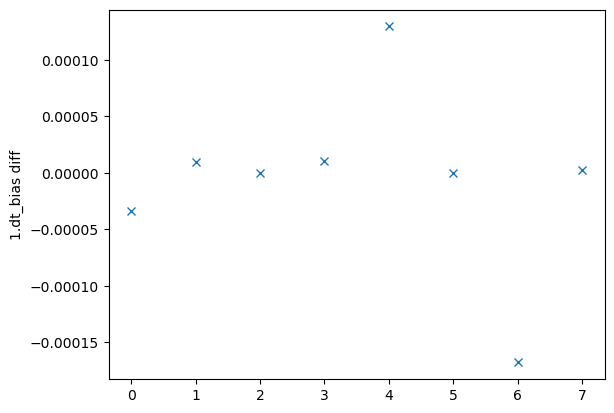

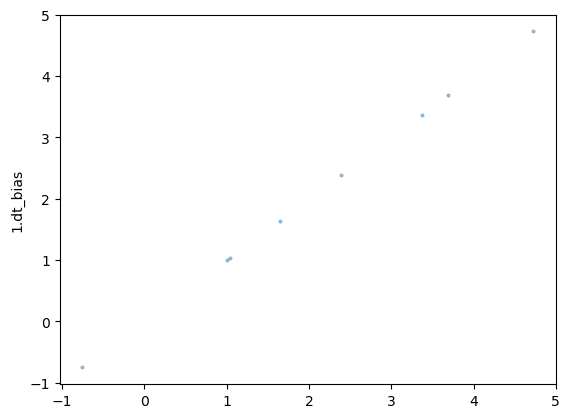

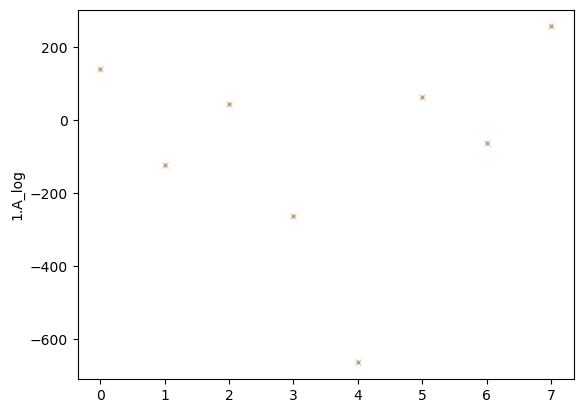

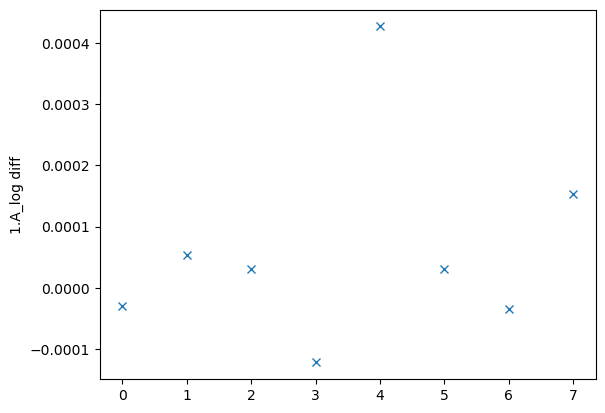

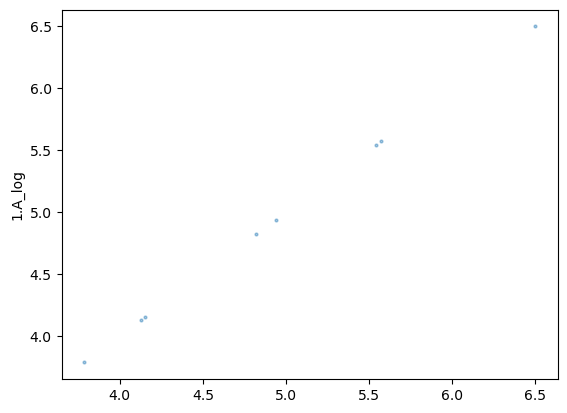

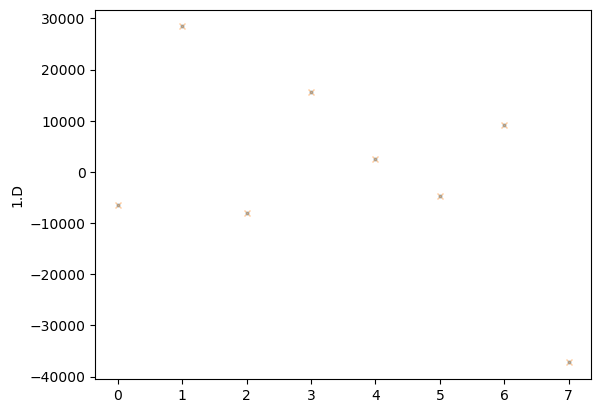

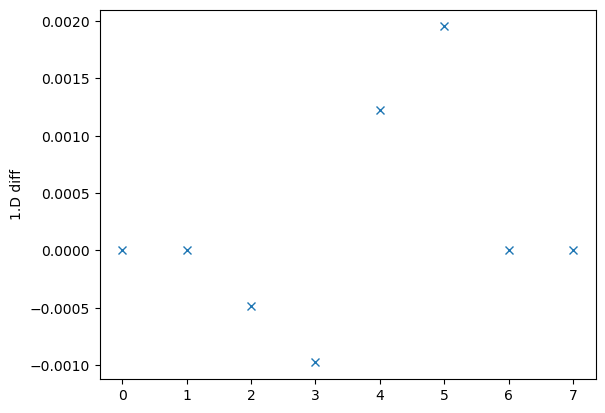

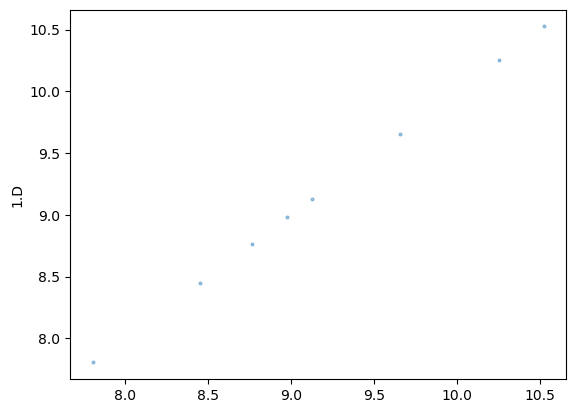

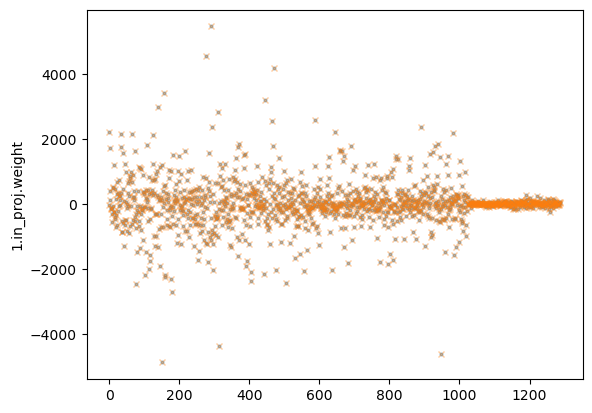

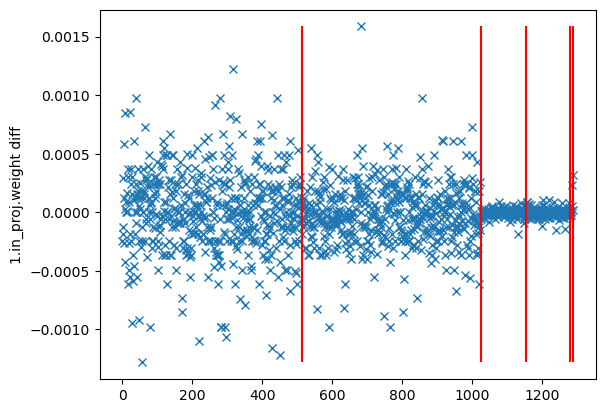

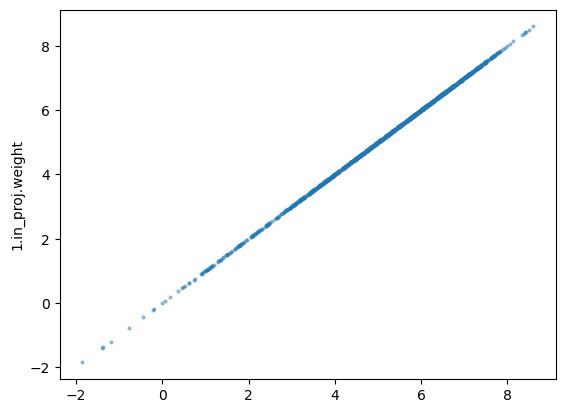

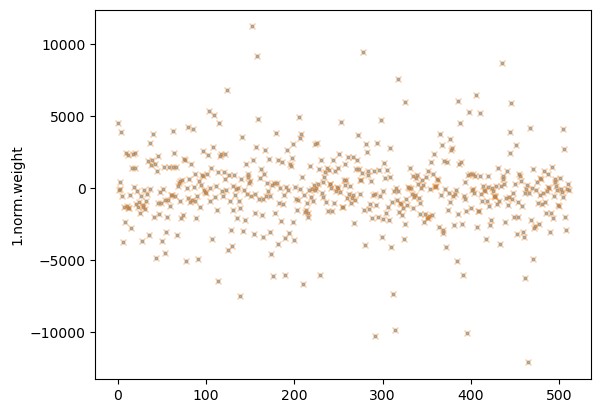

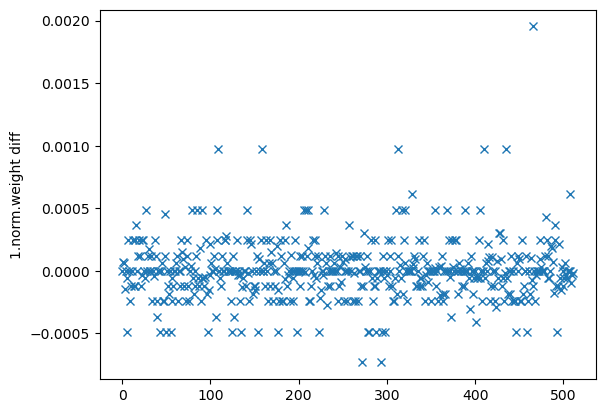

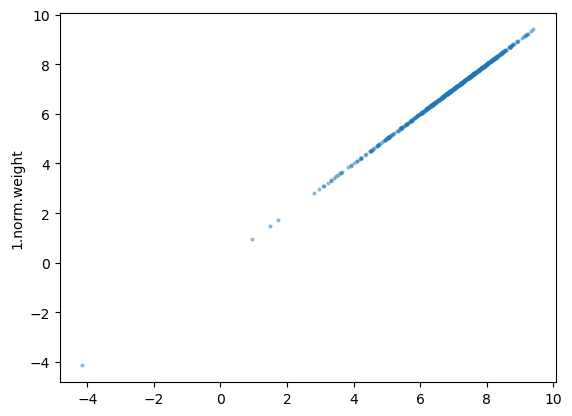

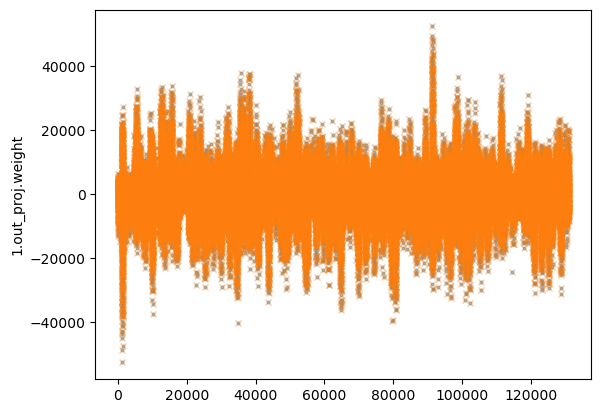

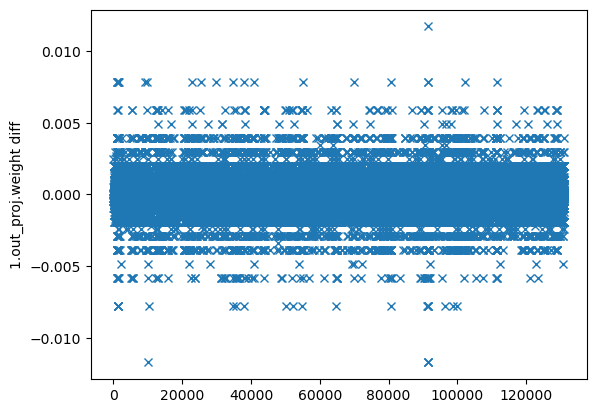

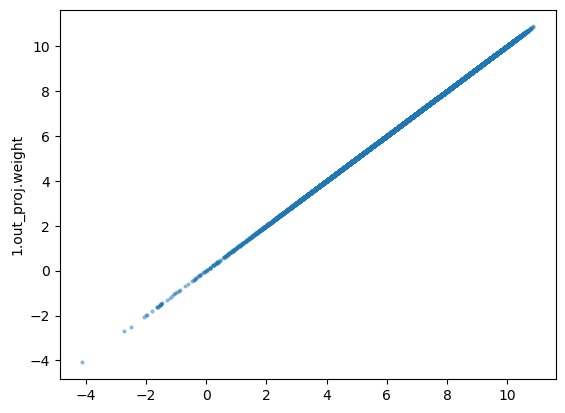

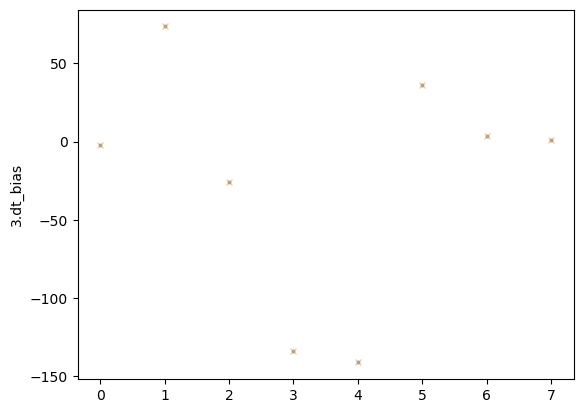

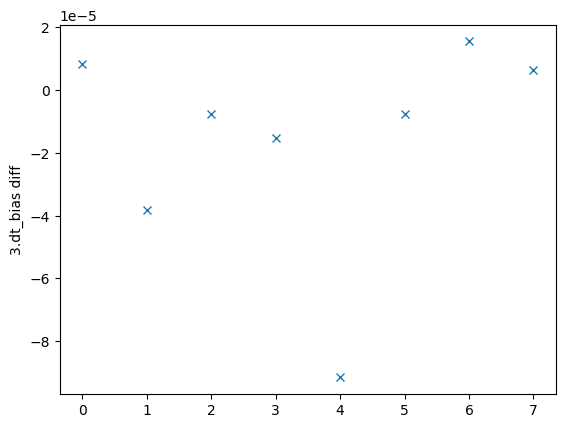

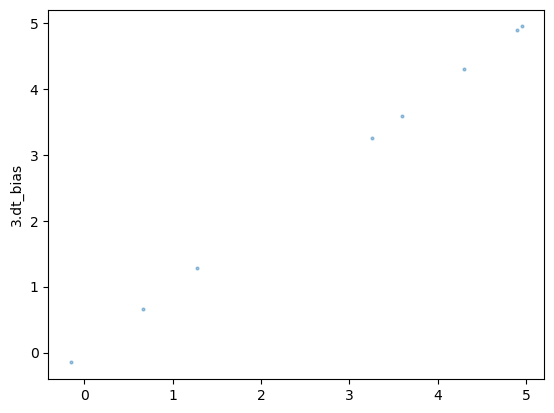

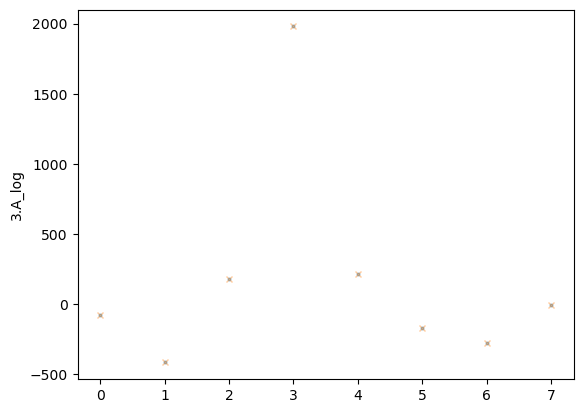

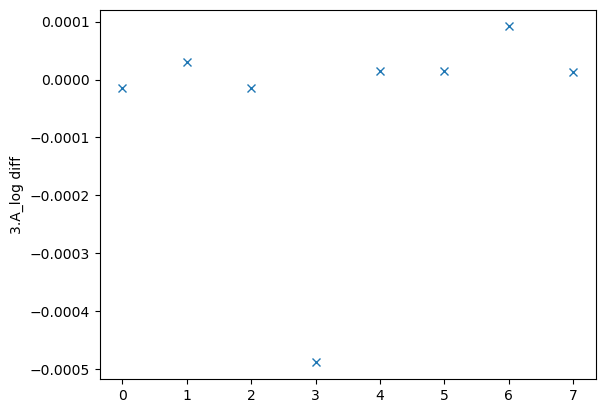

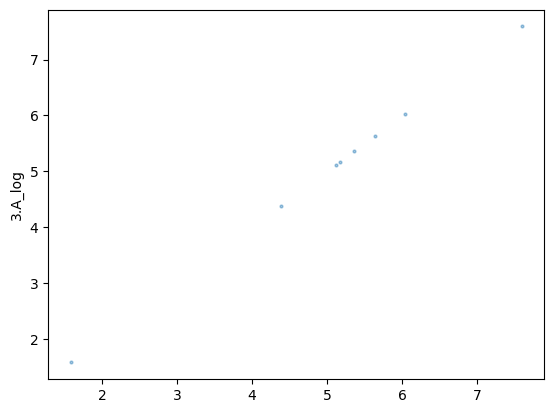

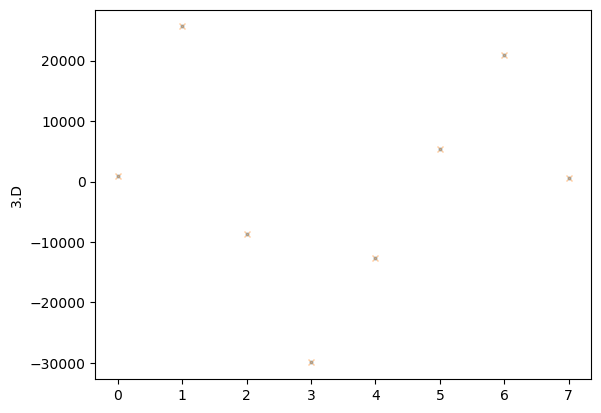

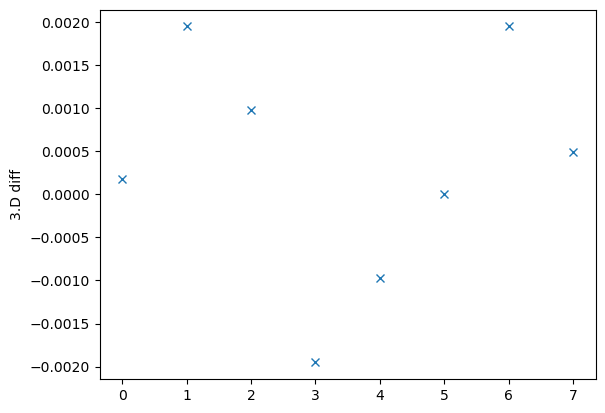

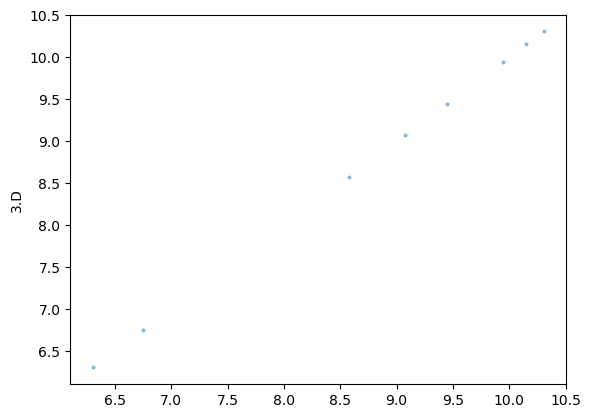

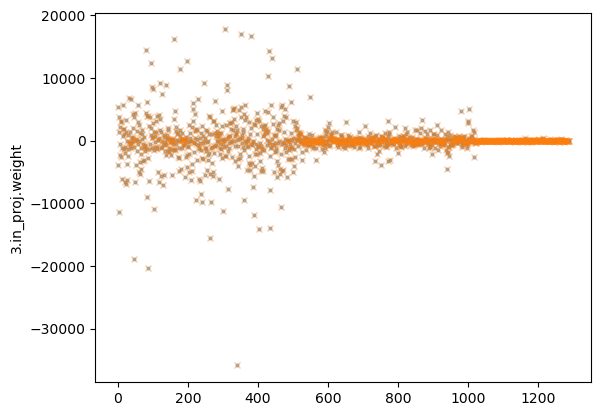

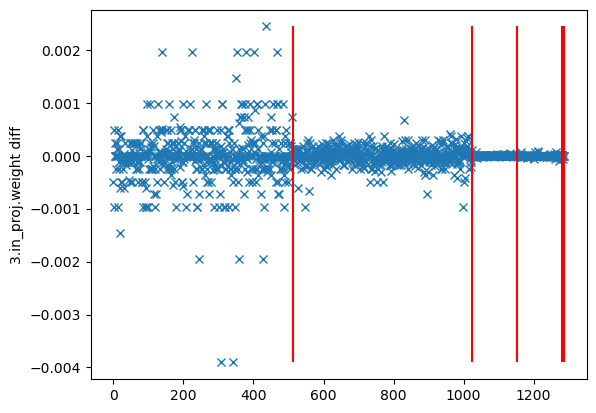

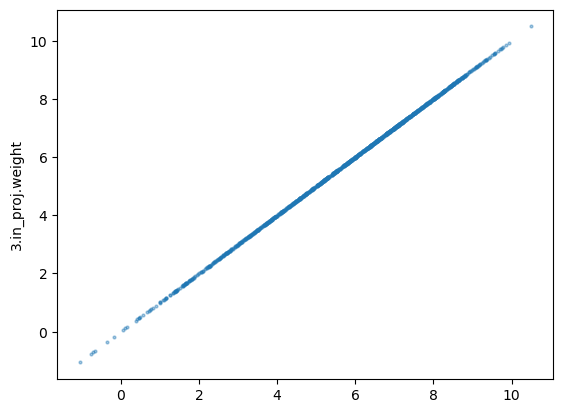

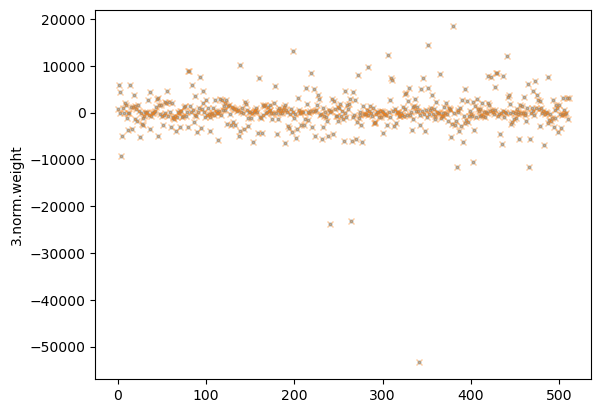

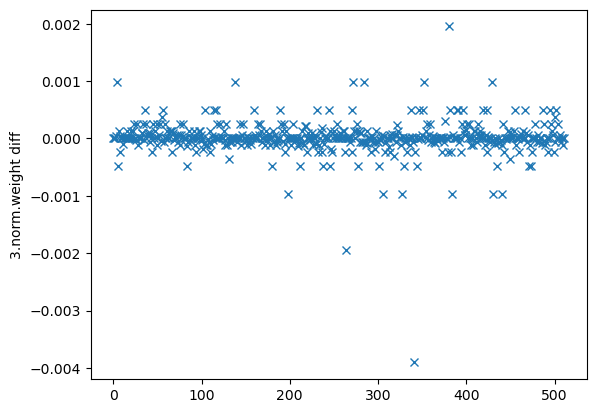

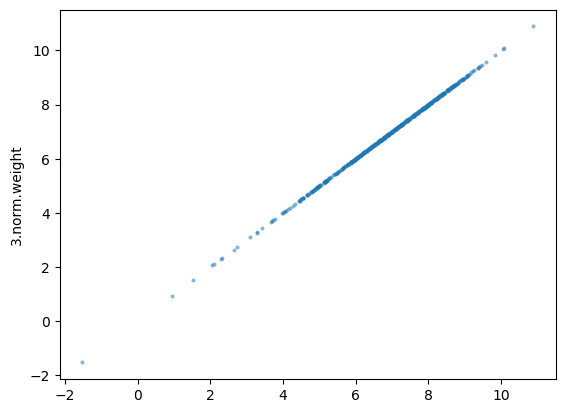

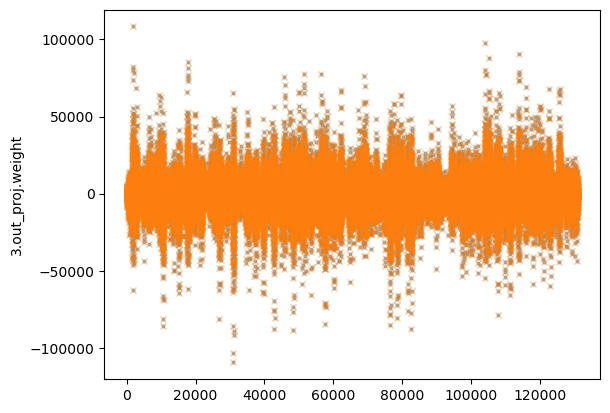

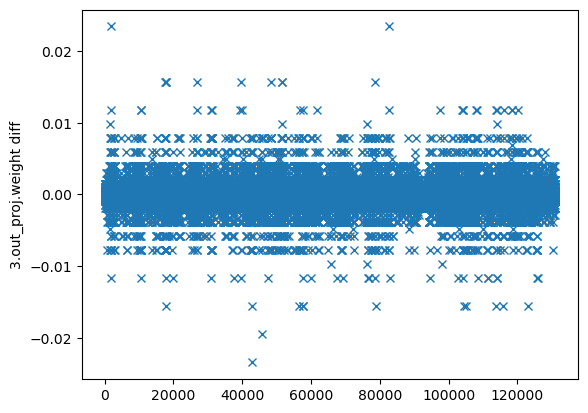

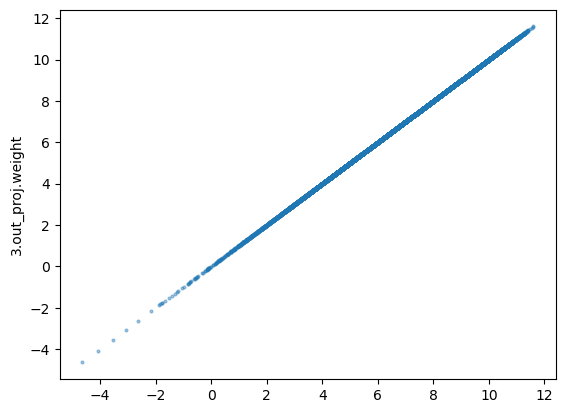

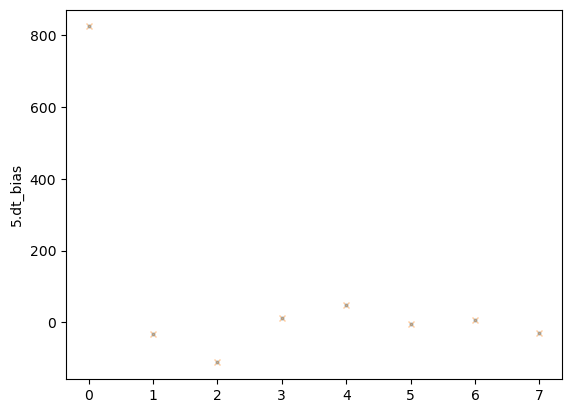

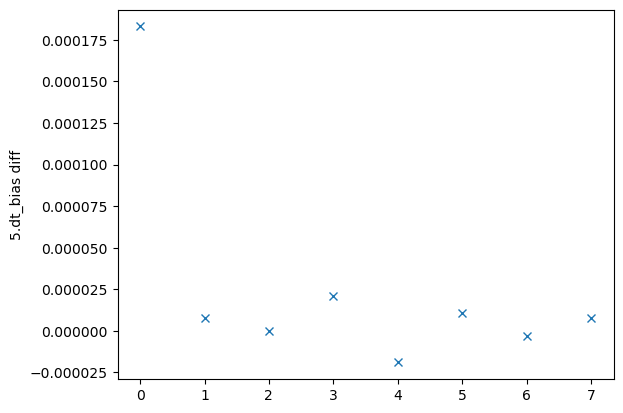

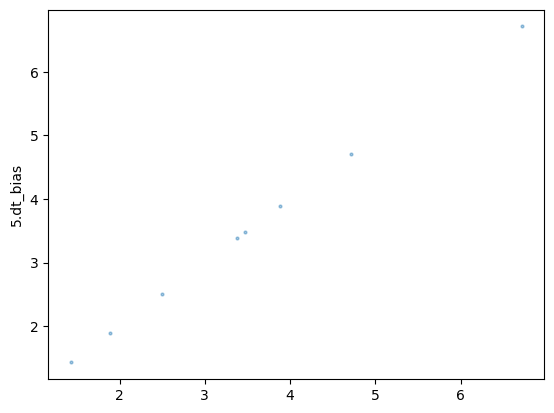

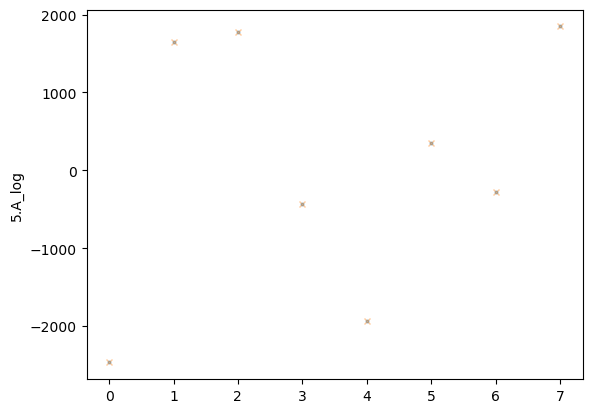

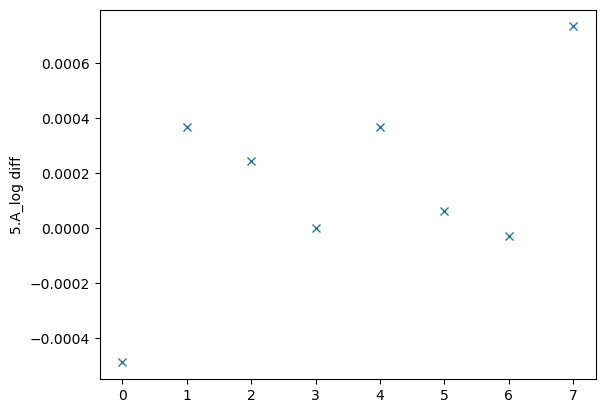

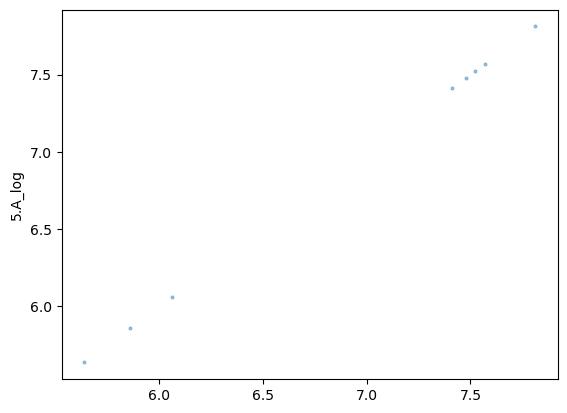

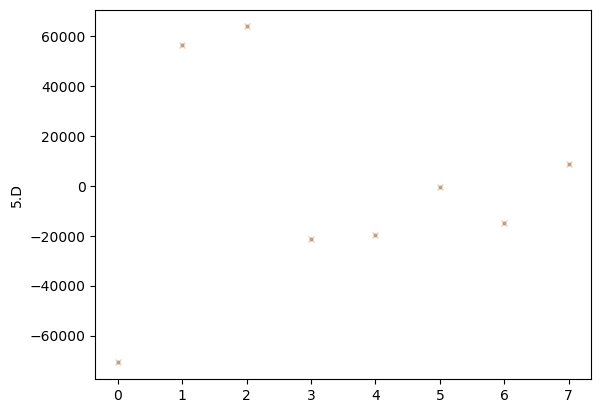

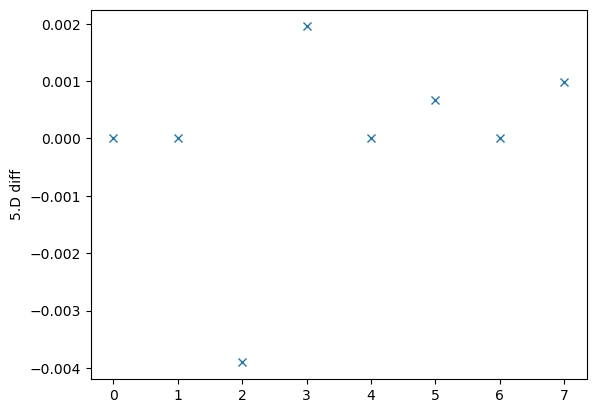

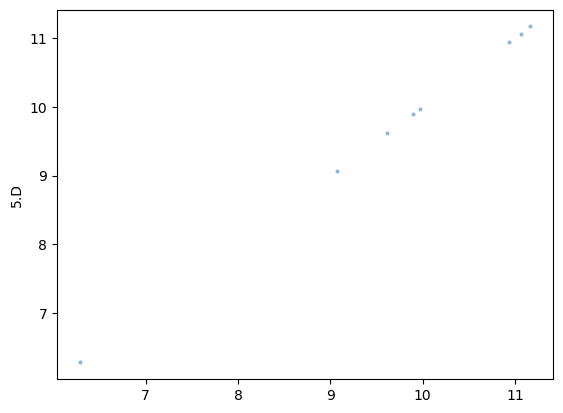

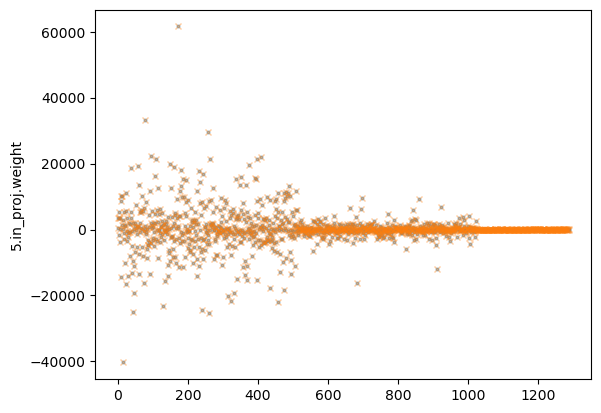

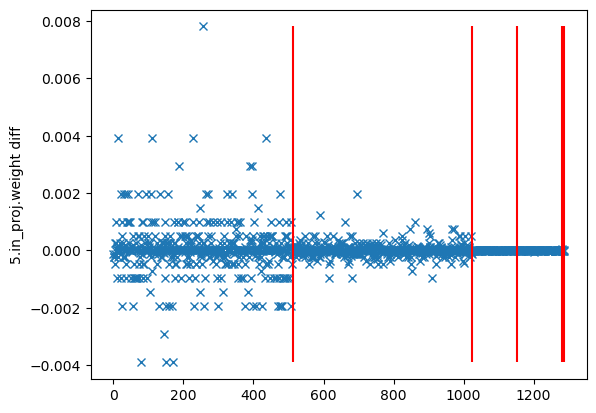

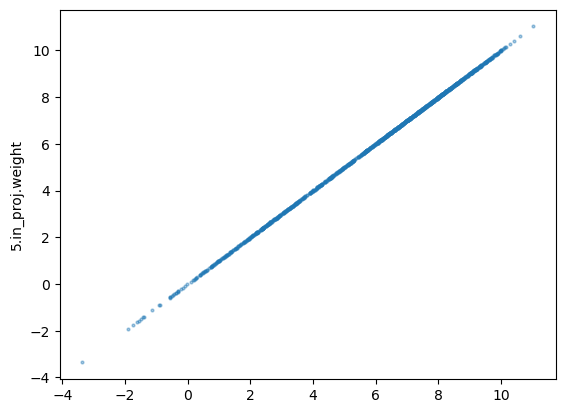

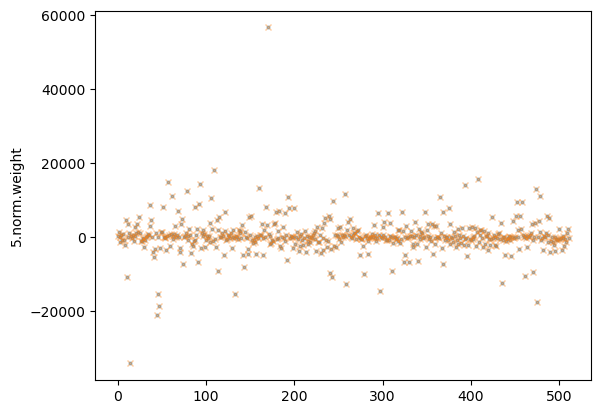

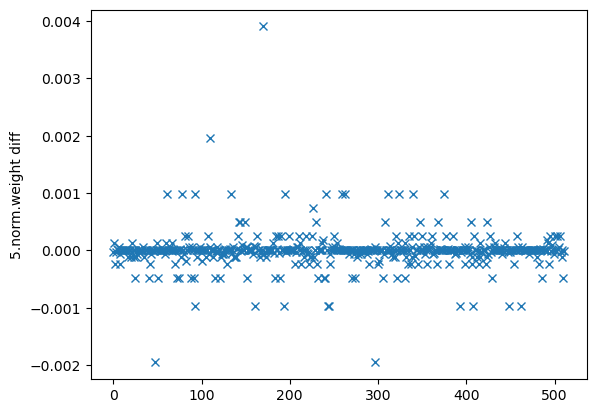

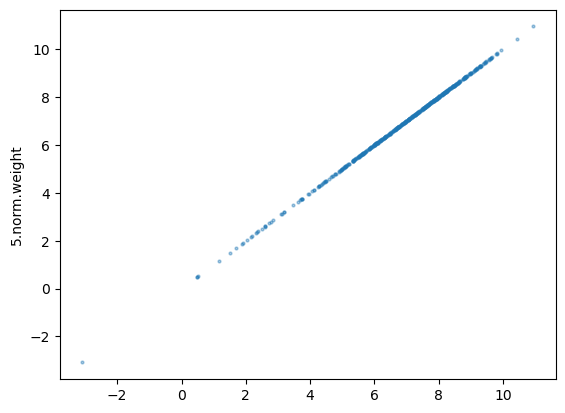

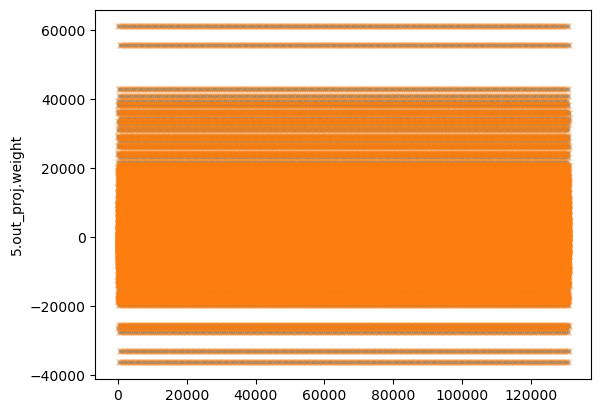

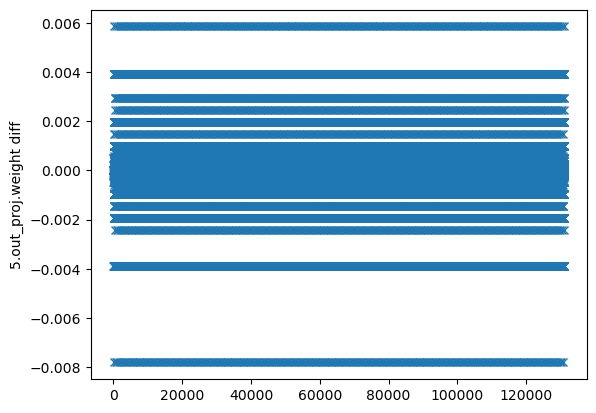

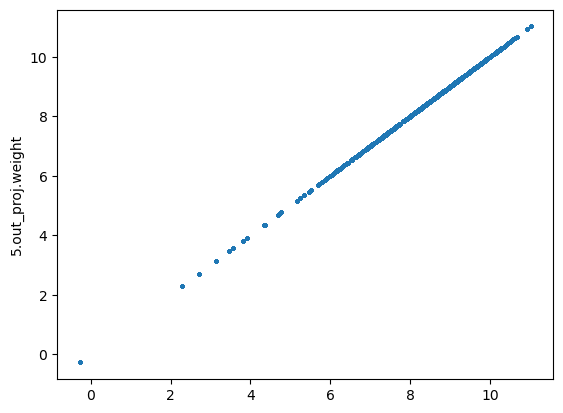

In [19]:
import numpy as np
import matplotlib.pyplot as plt
for (k,v),(k2,v2) in zip(ser_dict['grad_dict'][0].items(),dist_dict['grad_dict'][0].items()):
    #plt.plot((torch.cat(dist_dict['output'], dim=1).sum(dim=(0,2)).detach()-ser_dict['output'][0].sum(dim=(0,2)).detach()).div(ser_dict['output'][0].sum(dim=(0,2)).detach()))
    #print(v.shape, v2.shape,k, k2)
    if 'conv' in k:
        continue
    v2 = v2.clone()
    print(v2.shape,dist_dict['grad_dict'][1][k2].shape)
    for x in range(1,len(dist_dict['grad_dict'])):
        v2+=dist_dict['grad_dict'][x][k2]
    print(k,v.shape,v2.shape,(v-v2).div(v).abs().mean())
    if 'in_proj' in k:
        v = v[:,0]
        v2 = v2[:,0]
    l = list(range(v.flatten().shape[0]))
    print(k,'plots')
    plt.figure()
    plt.plot(l,v2.flatten(),'o',markersize=2,alpha=0.4)
    plt.plot(l,v.flatten(),'x',markersize=4,alpha=0.4)
    plt.ylabel(k)
    plt.figure()
    plt.plot(v.flatten()-v2.flatten(),'x')
    if 'in_proj' in k:
        d_inner = 2*256 
        d_state= 128
        nheads = d_inner / 64
        dims = np.cumsum([d_inner, d_inner, d_state, d_state, nheads]) # z,x,B,C,dt
        vlines = dims
        plt.vlines(vlines,(v-v2).min(),(v-v2).max(),'r',alpha=1.0)
    plt.ylabel(k + " diff")
    plt.figure()
    plt.plot(v.flatten().abs().log(),v2.flatten().abs().log(),'o',markersize=2,alpha=0.4)
    plt.ylabel(k)

In [65]:
for (k,v),(k2,v2) in zip(ser_dict['grad_dict'][0].items(),dist_dict['grad_dict'][1].items()):
    #plt.plot((torch.cat(dist_dict['output'], dim=1).sum(dim=(0,2)).detach()-ser_dict['output'][0].sum(dim=(0,2)).detach()).div(ser_dict['output'][0].sum(dim=(0,2)).detach()))
    #print(v.shape, v2.shape,k, k2)
    print(k,v.shape,(v-v2).div(v).mean())
    #plt.figure()
    #plt.hist((v-v2).div(v).flatten())

dt_bias torch.Size([8]) tensor(1.1085)
A_log torch.Size([8]) tensor(0.4799)
D torch.Size([8]) tensor(0.8784)
in_proj.weight torch.Size([1288, 256]) tensor(0.9755)
conv1d.weight torch.Size([768, 1, 4]) tensor(0.9007)
conv1d.bias torch.Size([768]) tensor(0.8742)
norm.weight torch.Size([512]) tensor(0.8665)
out_proj.weight torch.Size([256, 512]) tensor(0.8665)


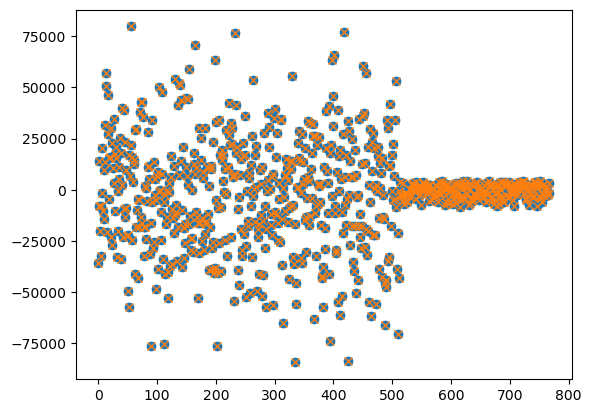

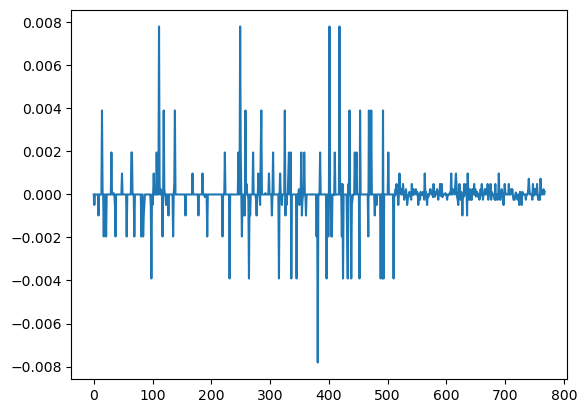

In [80]:
v=[]
for k in ['dx','dB','dC']:
    v.append(torch.cat([rearrange(x, 'b s h d-> b s (h d)') for x in dist_dict[k]],dim=1))
xBC_d_calc = torch.cat(v, dim=2).sum(dim=[0,1])
v2 = ser_dict['dxBC']
xBC_d = torch.cat([v2[0]] + [x[:,3:] for x in v2[1:]],dim=1).sum(dim=[0,1])
plt.plot(xBC_d_calc,'o')
plt.plot(xBC_d,'x')
plt.figure()
plt.plot(xBC_d_calc-xBC_d)

input
output
output
output output torch.Size([8, 8192, 256]) torch.Size([8, 1024, 256])
torch.Size([8, 8192, 256]) torch.Size([8, 8192, 256])
[0, 2]
grad_dict


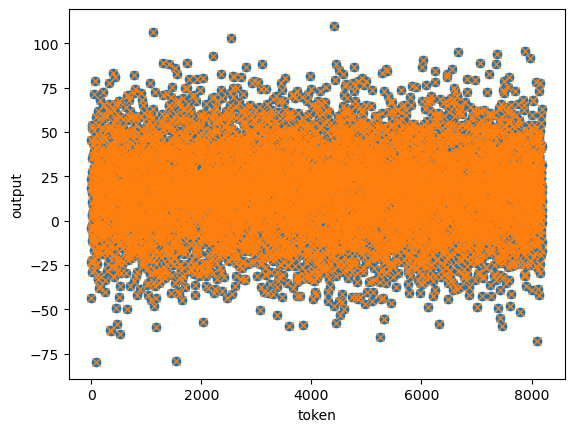

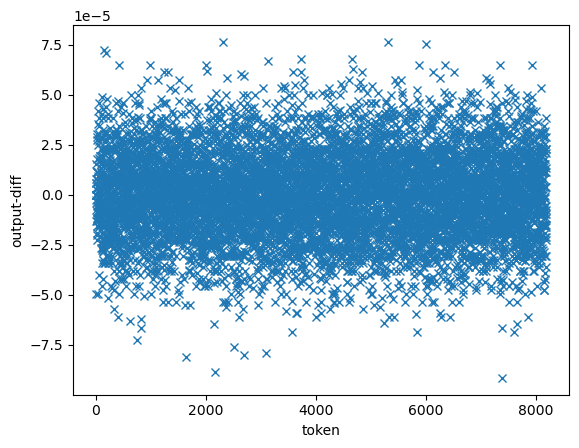

In [15]:
from einops import rearrange
for (k,v),(k2,v2) in zip(ser_dict.items(),dist_dict.items()):
    print(k)
    if k in ['grad_dict','final_states','input','rstd','dA']:
        continue
    if k in ['ddt']:
        v = [rearrange(x,'i j c k -> i c j k') for x in v]
        v2 = [rearrange(x,'i j c k-> i c j k') for x in v2]
    if k in ['dz','dz_i','dout','dy_rms','x_rms','z_rms']:
        v = [rearrange(x, '(b s) d -> b s d', b = 8) for x in v]
        v2 = [rearrange(x, '(b s) d -> b s d', b = 8) for x in v2]
    if k in ['rmsnorm_weight']:
        print(v)
        v = [torch.cat([v[0].unsqueeze(0) for _ in range(len(v2))], dim=1)]
        v2 = [x.unsqueeze(0) for x in v2]
    if k in ['zxbcdt', 'dzxbcdt','dxBC','dxBC_p','dxBC_given']:
        v2 = [v2[0]] + [x[:,3:] for x in v2[1:]]
    if k in ['ddA_chunk_cumsum']:
        v = [rearrange(x,'i j c -> i c j') for x in v]
        v2 = [rearrange(x,'i j c -> i c j') for x in v2]
    if k in ['dx']:
        v2 = [rearrange(x, 'b s h d-> b s (h d)') for x in v2]
        v = [rearrange(x, 'b s h d-> b s (h d)') for x in v]

    print(k)
    print(k,k2,v[0].shape,v2[0].shape)
    v1_cat = v[0].detach()
    v2_cat = torch.cat(v2, dim=1).detach()
    if k in ['zxbcdt', 'dzxbcdt','dxBC','dxBC_p','dxBC_given']:
        v1_cat = rearrange(v1_cat,'i j c -> i c j')
        v2_cat = rearrange(v2_cat,'i j c -> i c j')

    print(v1_cat.shape,v2_cat.shape)
    dim = [0] + list(range(v1_cat.dim()))[2:]
    print(dim)
    plt.figure()
    plt.ylabel(k)
    plt.xlabel('token')
    plt.plot(v1_cat.sum(dim=dim),'o')
    plt.plot(v2_cat.sum(dim=dim),'x')
    try:
        plt.figure()
        plt.plot(v1_cat.sum(dim=dim)-v2_cat.sum(dim=dim),'x')
        plt.ylabel(k + '-diff')
        plt.xlabel('token')
    except:
        print("nope" + k)

In [38]:
v2.dim()

AttributeError: 'list' object has no attribute 'dim'

In [38]:
6*128

768

In [1]:
import torch

In [6]:
torch.randn([4,6]).split(3)

(tensor([[-0.1357, -1.9820,  0.1542, -1.0510, -0.3510, -1.0124],
         [ 2.2448, -0.3889,  1.9162, -0.4601,  0.1914,  0.9910],
         [ 1.7115,  1.0046, -0.0459, -1.9433,  0.6395,  0.7899]]),
 tensor([[ 0.9299,  1.2479,  0.4007, -0.5585,  1.1961, -0.5666]]))